In [1]:
import graph_data as gd
import time
import torch
from models import TreeSupport
from torch import optim
from torch.nn import MSELoss
from torch.utils.data import random_split, ConcatDataset
from torch_geometric.data import DataLoader
from Bio import Phylo as phy

# Datasets
## Prepare trees and reconstructed sequences

In [2]:
data_path = 'data/'

In [3]:
target_tree = phy.read(data_path+'tree/Fungi45_infer/Fungi.tre', 'newick')
#all_data = gd.Trees.load_ready_trees(data_path+'tree/Fungi45_infer/fml_output/', data_path+'tree/Fungi45_infer/fml_output/*.tre', target_tree)  # INITIALIZE NEW DS
fungi_data = gd.Trees(data_path+'tree/Fungi45_infer/', data_path+'alns/Fungi45/', target_tree)
fungi_data.data.x = fungi_data.data.x.float()
fungi_data.data.edge_attr = (torch.max(fungi_data.data.edge_attr)+0.001 - fungi_data.data.edge_attr).float()
fungi_data.data.edge_index = fungi_data.data.edge_index.long()

In [4]:
target_tree = phy.read(data_path+'tree/arch_fung/Archaea.tre', 'newick')
#archaea_data = gd.Trees.load_ready_trees(data_path+'tree/Archaea/fml_output/', data_path+'tree/Archaea/fml_output/*.tre', target_tree)  # INITIALIZE NEW DS //delete temp_tree
archaea_data = gd.Trees(data_path+"tree/Archaea/", data_path+"alns/Archaea/", target_tree)
archaea_data.data.x = archaea_data.data.x.float()
archaea_data.data.edge_attr = (torch.max(archaea_data.data.edge_attr)+0.001 - archaea_data.data.edge_attr).float()
archaea_data.data.edge_index = archaea_data.data.edge_index.long()

In [5]:
# concatenate datasets
all_data =  ConcatDataset([fungi_data, archaea_data])

In [6]:
# data preparation
train_batch = 1000
test_batch = 1000
# data loaders
train, test = random_split(
    all_data, [round(len(all_data) * 0.8), round(len(all_data) * 0.2)]
)

# Train model

In [7]:
train_dl = DataLoader(
    train, batch_size=train_batch, pin_memory=True, num_workers=3
)
test_dl = DataLoader(
    test, batch_size=test_batch, num_workers=2
)

In [8]:
model = TreeSupport(231, 400)
model = model.cuda()
silent = False
num_epochs = 200
loss_fn = MSELoss()
test_batches = len(test_dl)
# stattr
losses = []
val_losses = []
learning_rates = []

In [9]:
# interactive descending lr for less loss
optimizer = optim.AdamW(model.parameters(), lr=0.0003)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, verbose=True, cooldown=2, patience=5
)
num_epochs = 600
start = time.time()
for epoch in range(num_epochs):
    model.train()
    for data in train_dl:
        data = data.to(torch.device('cuda'))
        optimizer.zero_grad()
        out = model(data)
        loss = loss_fn(out, data.y)
        losses.append(loss.item())  # history
        # optimize
        loss.backward()
        optimizer.step()

        # stats
        learning_rates.append(-1)

    # evaluation
    model.eval()
    agg_loss = 0
    with torch.autograd.no_grad():
        for data in test_dl:
            data = data.to(torch.device('cuda'))
            out = model(data)
            agg_loss += loss_fn(out, data.y)
        val_losses.append(agg_loss.item()/test_batches)
    scheduler.step(agg_loss)
    if not silent:
        print(
            "Epoch [{}/{}], Loss (last training batch/val): {:.4f}/{:.4f}. Time elapsed: {:.2f}".format(
                epoch + 1,
                num_epochs,
                losses[-1],
                val_losses[-1],
                time.time() - start,
            )
        )

Epoch [1/600], Loss (last training batch/val): 0.4372/0.3574. Time elapsed: 1.81
Epoch [2/600], Loss (last training batch/val): 0.3595/0.3438. Time elapsed: 3.37
Epoch [3/600], Loss (last training batch/val): 0.3403/0.3326. Time elapsed: 4.93
Epoch [4/600], Loss (last training batch/val): 0.3301/0.3274. Time elapsed: 6.49
Epoch [5/600], Loss (last training batch/val): 0.3213/0.3225. Time elapsed: 8.10
Epoch [6/600], Loss (last training batch/val): 0.3136/0.3233. Time elapsed: 9.66
Epoch [7/600], Loss (last training batch/val): 0.3073/0.3147. Time elapsed: 11.23
Epoch [8/600], Loss (last training batch/val): 0.3037/0.3153. Time elapsed: 12.79
Epoch [9/600], Loss (last training batch/val): 0.3006/0.3114. Time elapsed: 14.36
Epoch [10/600], Loss (last training batch/val): 0.3002/0.3110. Time elapsed: 15.94
Epoch [11/600], Loss (last training batch/val): 0.2949/0.3361. Time elapsed: 17.50
Epoch [12/600], Loss (last training batch/val): 0.2935/0.3387. Time elapsed: 19.08
Epoch [13/600], Los

# Learning stats

In [10]:
import pandas as pd
import numpy as np
import altair as alt

alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

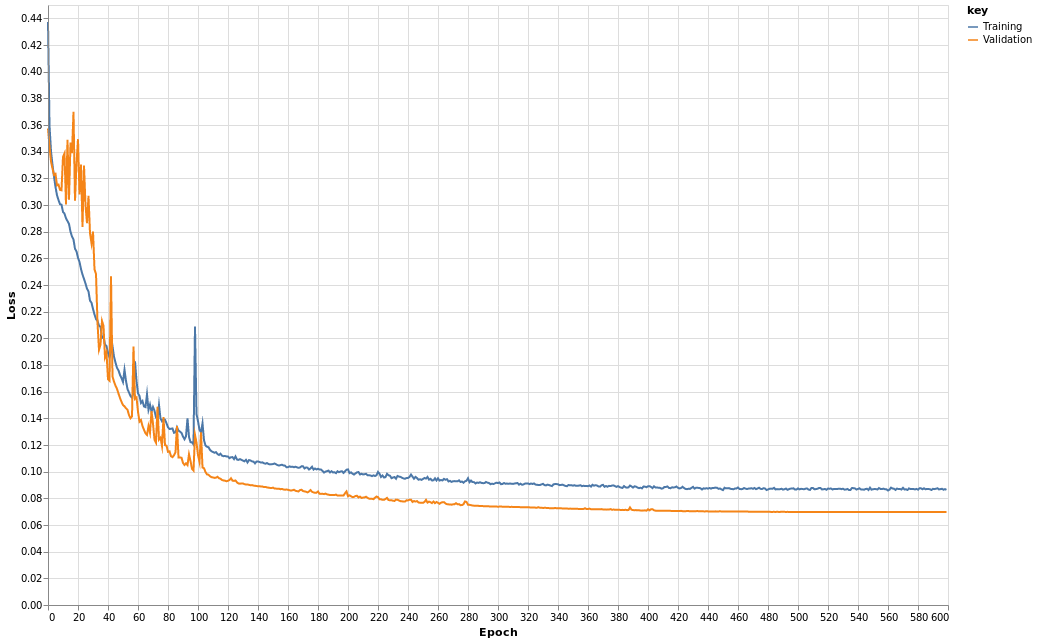

In [11]:
adata = pd.DataFrame(
    {
        "LR": learning_rates[len(train_dl)-1::len(train_dl)],
        "Training":losses[len(train_dl)-1::len(train_dl)], 
        "Validation":val_losses
    }
).reset_index()
alt.Chart(adata, width=900, height=600).transform_fold(["Training", "Validation"]).mark_line().encode(
    x=alt.X("index", axis=alt.Axis(title='Epoch')),
    y=alt.Y("value:Q", title="Loss"),
    color="key:N"
)

In [12]:
nplist = list()
for data in test_dl:
    with torch.no_grad():
        data.x, data.edge_index, data.edge_attr = data.x.float(), data.edge_index.long(), data.edge_attr.float()  # CLEAN IT!!!!!
        out = model(data.to(torch.device('cuda')))
        nplist.append(np.concatenate([data.y.cpu().numpy(), out.detach().cpu().numpy()], axis=1))

In [13]:
results = pd.DataFrame(np.concatenate(nplist, 0), columns=['actual', 'predicted'])

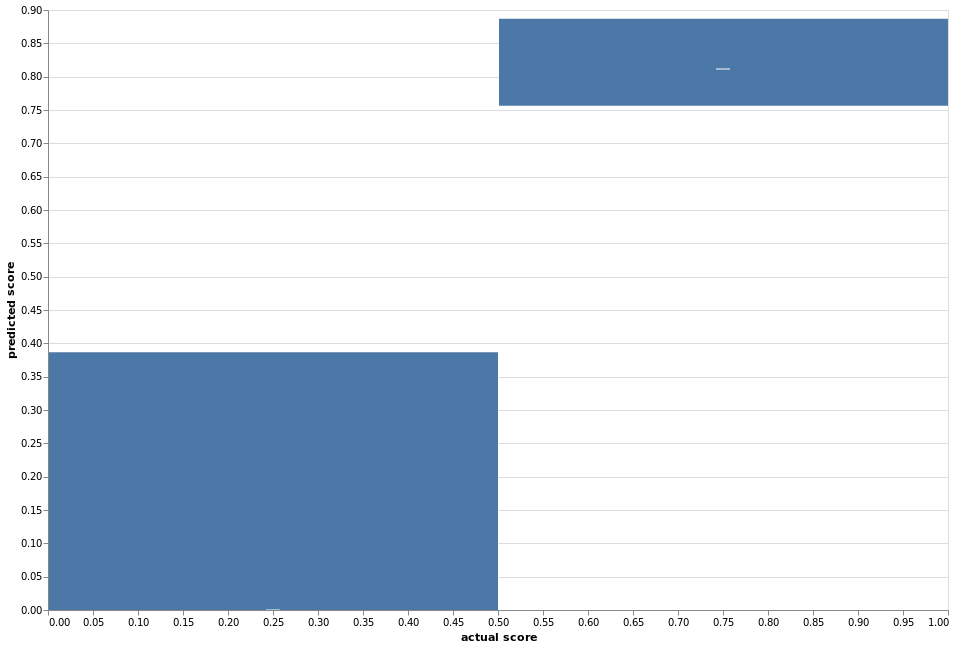

In [14]:
alt.Chart(results, width=900, height=600).mark_boxplot(opacity=1).encode(
    x=alt.X("actual:Q", bin=alt.Bin(maxbins=2), axis=alt.Axis(title='actual score')),
    y=alt.Y("predicted", axis=alt.Axis(title='predicted score'))
)

Модель хорошо предсказывает хорошие ветви. Рассмотрим ее как бинарный классификатор с параметром T.

In [15]:
torch.save(model.state_dict(), 'models/2gin_1sage_PAIRS(FUNGI_ARCHAEA).dct')

In [16]:
import sklearn.metrics as metrics

pred_act = results>0.5

fpr, tpr, threshold = metrics.roc_curve(results["actual"]==1, results["predicted"])
roc_data = pd.DataFrame({"True Positive Rate": tpr, "False Positive Rate": fpr})


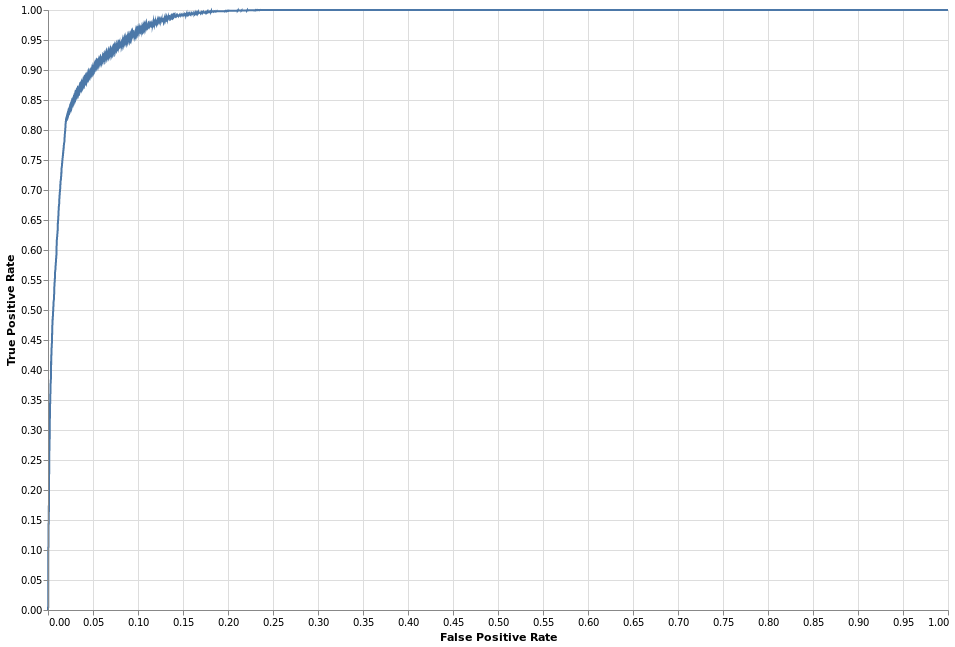

In [17]:
alt.Chart(roc_data, width=900, height=600).mark_line().encode(
    x="False Positive Rate",
    y="True Positive Rate"
)

In [18]:
metrics.roc_auc_score(results["actual"]==1, results["predicted"])

0.983103859815907

In [20]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
optimal_threshold

0.6284579

In [21]:
metrics.accuracy_score(results["actual"]==1, results["predicted"]>0.628)

0.9333520438486429

## Test with completely different data

In [23]:
# data
target_tree = phy.read(data_path+'tree/Other_eukaryota_2018.tre', 'newick')
test_dataset = gd.Trees(
    data_path+"tree/Eukaryota/",
    data_path+"alns/other_eukaryota_2018/",
    target_tree
)
test_dataset.data.x = test_dataset.data.x.float()
test_dataset.data.edge_attr = (torch.max(test_dataset.data.edge_attr)+0.001 - test_dataset.data.edge_attr).float()
test_dataset.data.edge_index = test_dataset.data.edge_index.long()

In [24]:
nplist = list()
for data in test_dataset:
    with torch.no_grad():
        data.x, data.edge_index, data.edge_attr = data.x.float(), data.edge_index.long(), data.edge_attr.float()  # CLEAN IT!!!!!
        out = model(data.to(torch.device('cuda')))
        nplist.append(np.concatenate([data.y.cpu().numpy(), out.detach().cpu().numpy()], axis=1))

In [25]:
test_results = pd.DataFrame(np.concatenate(nplist, 0), columns=['actual', 'predicted'])

In [26]:
pred_act = test_results>0.5

fpr, tpr, threshold = metrics.roc_curve(test_results["actual"]==1, test_results["predicted"])
roc_data = pd.DataFrame({"True Positive Rate": tpr, "False Positive Rate": fpr})


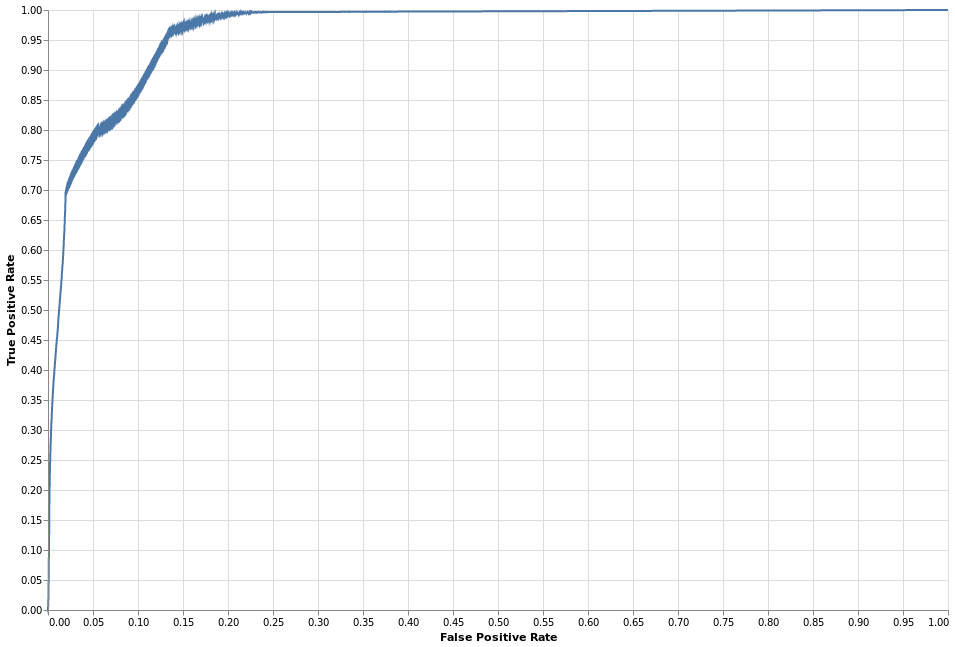

In [27]:
alt.Chart(roc_data, width=900, height=600).mark_line().encode(
    x="False Positive Rate",
    y="True Positive Rate"
)

In [28]:
metrics.roc_auc_score(test_results["actual"]==1, test_results["predicted"])

0.9663619490201709

In [29]:
metrics.accuracy_score(test_results["actual"]==1, test_results["predicted"]>0.628)

0.8817379472658404

In [31]:
torch.save(model.state_dict(), 'models/2gin_1sage_PAIRS(FUNGI_ARCHAEA).dct')

# Further assessment

In [43]:
# first half of the nodes
nplist = list()
for data in test_dataset:
    with torch.no_grad():
        data.x, data.edge_index, data.edge_attr = data.x.float(), data.edge_index.long(), data.edge_attr.float()  # CLEAN IT!!!!!
        out = model(data.to(torch.device('cuda')))[:60]
        nplist.append(np.concatenate([data.y.cpu()[:60].numpy(), out.detach().cpu().numpy()], axis=1))
test_results = pd.DataFrame(np.concatenate(nplist, 0), columns=['actual', 'predicted'])
test_results.describe()

,actual,predicted
count,1.378800e+05,137880.000000
mean,4.496009e-01,0.445949
std,4.964652e-01,0.397463
min,1.925930e-34,0.000000
25%,1.525879e-05,0.000000
50%,9.765625e-04,0.556107
75%,1.000000e+00,0.836779
max,1.000000e+00,1.468934


In [35]:
fpr, tpr, threshold = metrics.roc_curve(test_results["actual"]==1, test_results["predicted"])
roc_data = pd.DataFrame({"True Positive Rate": tpr, "False Positive Rate": fpr})

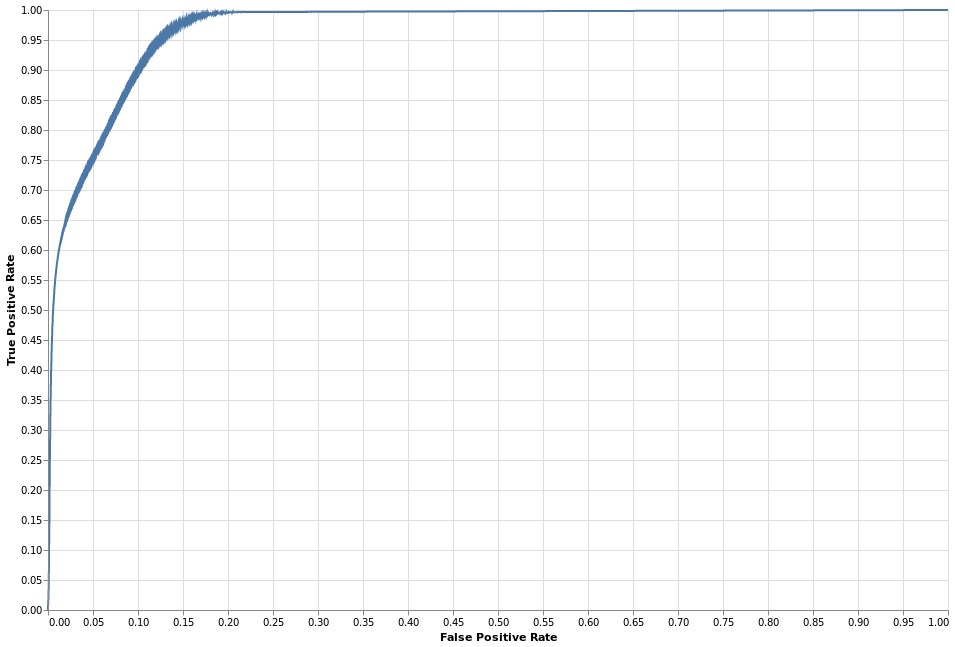

In [36]:
alt.Chart(roc_data, width=900, height=600).mark_line().encode(
    x="False Positive Rate",
    y="True Positive Rate"
)

In [37]:
# second half
nplist = list()
for data in test_dataset:
    with torch.no_grad():
        data.x, data.edge_index, data.edge_attr = data.x.float(), data.edge_index.long(), data.edge_attr.float()  # CLEAN IT!!!!!
        out = model(data.to(torch.device('cuda')))
        nplist.append(np.concatenate([data.y.cpu().numpy(), out.detach().cpu().numpy()], axis=1))
test_results = pd.DataFrame(np.concatenate(nplist, 0), columns=['actual', 'predicted'])
test_results.describe()

In [51]:
prec, rec, threshold = metrics.precision_recall_curve(test_results["actual"]==1, test_results["predicted"])
roc_data = pd.DataFrame({"Precision": prec, "Recall": rec})

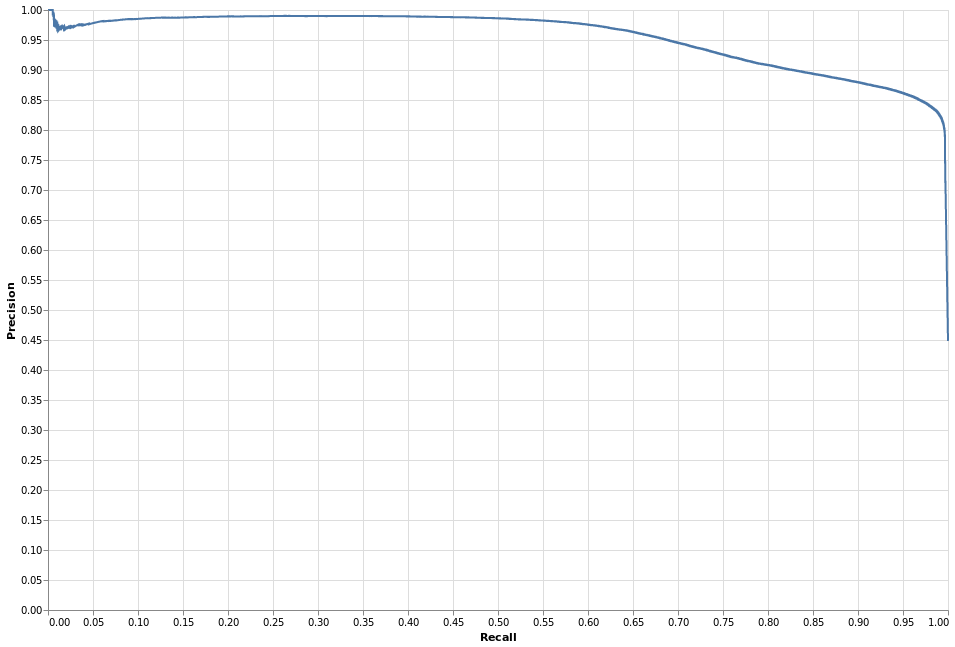

In [52]:
alt.Chart(roc_data, width=900, height=600).mark_line().encode(
    x="Recall",
    y="Precision"
)

In [54]:
test_results.describe()

,actual,predicted
count,1.378800e+05,137880.000000
mean,4.496009e-01,0.445949
std,4.964652e-01,0.397463
min,1.925930e-34,0.000000
25%,1.525879e-05,0.000000
50%,9.765625e-04,0.556107
75%,1.000000e+00,0.836779
max,1.000000e+00,1.468934


In [55]:
metrics.confusion_matrix(test_results["actual"]==1, test_results["predicted"]>0.628)


array([[69340,  6697],
       [ 8207, 53636]])